In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso    
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('time-series-19-covid-combined.csv', parse_dates=True)

In [3]:
# Setting the 'Date' datetime datatype
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
data['currentCase'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

In [5]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,currentCase
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,0.0


In [6]:
data.drop(columns=['Province/State'], inplace=True)

In [7]:
us_query = data[data['Country/Region'] == 'US']
us_df = us_query[['Date', 'Confirmed', 'Deaths', 'Recovered', 'currentCase']]

In [8]:
us_df.head()

,Date,Confirmed,Deaths,Recovered,currentCase
29403,2020-01-22,1.0,0.0,0.0,1.0
29404,2020-01-23,1.0,0.0,0.0,1.0
29405,2020-01-24,2.0,0.0,0.0,2.0
29406,2020-01-25,2.0,0.0,0.0,2.0
29407,2020-01-26,5.0,0.0,0.0,5.0


Text(0, 0.5, 'Cummulative')

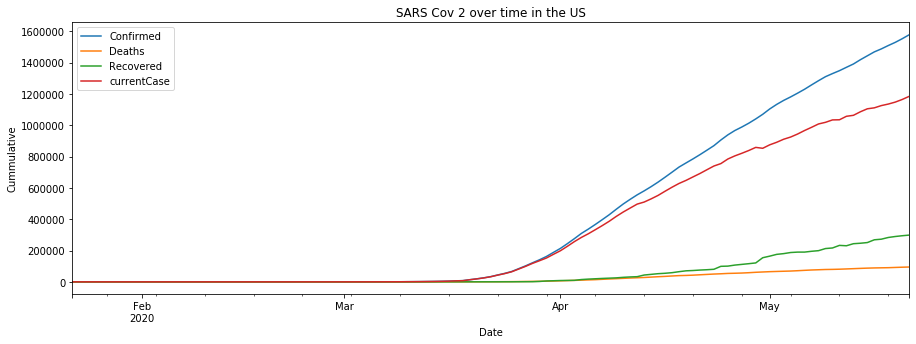

In [9]:
us_df.plot(x='Date',figsize=(15,5), title='SARS Cov 2 over time in the US')
plt.ylabel('Cummulative')

In [10]:
us_df.describe()

,Confirmed,Deaths,Recovered,currentCase
count,1.210000e+02,121.000000,121.000000,1.210000e+02
mean,4.040393e+05,22595.454545,54433.958678,3.270099e+05
std,5.286625e+05,31621.276872,88085.996917,4.131395e+05
min,1.000000e+00,0.000000,0.000000,1.000000e+00
25%,1.500000e+01,0.000000,5.000000,1.100000e+01
50%,3.328000e+04,587.000000,178.000000,3.251500e+04
75%,8.118650e+05,45086.000000,75204.000000,6.915750e+05
max,1.577147e+06,94702.000000,298418.000000,1.184027e+06


In [11]:
us_df.corr()

,Confirmed,Deaths,Recovered,currentCase
Confirmed,1.000000,0.996716,0.962868,0.998040
Deaths,0.996716,1.000000,0.976978,0.990578
Recovered,0.962868,0.976978,1.000000,0.944119
currentCase,0.998040,0.990578,0.944119,1.000000


In [12]:
def polyRegression(x=None, y=None, degree=1):
    """
        params: x array-like predictor
        params: y array-like target
    
    """
    scaler=MinMaxScaler() # MinMax
    lr=Lasso(alpha=100) #Lasso
    multi_rgr = MultiOutputRegressor(lr)
    
    Input = [('modal',multi_rgr)]
    pipe=Pipeline(Input)
    pipe.fit(x.reshape(-1, 1), y)
    #x=scaler.fit_transform()
    
    poly_pred=pipe.predict(x.reshape(-1, 1))
    
    #sorting predicted values with respect to predictor
    pred = []
    for i in range(y.shape[1]):
        sorted_zip = sorted(zip(x, poly_pred[:,i]))
        _, poly_pred1 = zip(*sorted_zip)
        pred.append(poly_pred1)
    
    
    return np.asfarray(pred).T, pipe

In [14]:
need_feature = ['Confirmed','Recovered','Deaths']
key_feat =  need_feature[0]
prediction, model = polyRegression(x=us_df[key_feat].values,
                                  y=us_df[['Deaths','Recovered','currentCase']].values, degree=7)

In [17]:
x=np.array([5000]).reshape(-1,1)
y=model.predict(x)
y

array([[-1194.18358181, -9585.30170325, 15779.48571696]])

In [19]:
df_predict = pd.DataFrame(prediction, columns=['Deaths','Recovered','currentCase'],
                          index=us_df.Date)
cols = ['Recovered', 'currentCase', 'Deaths']
for c in cols:
    score = np.sqrt(mean_squared_error(us_df[c] ,df_predict[c]))
    print('{}: RMSE for Polynomial Regression => {}\n'.format(c, score))

Recovered: RMSE for Polynomial Regression => 23682.458259359835

currentCase: RMSE for Polynomial Regression => 25744.700822747156

Deaths: RMSE for Polynomial Regression => 2550.157038849866



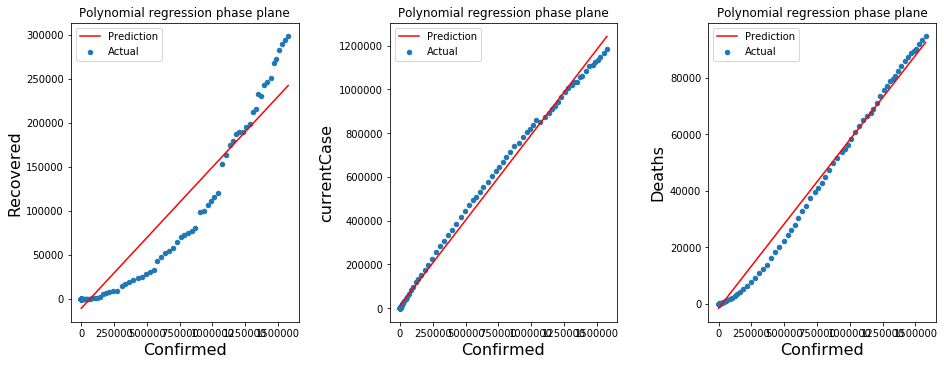

In [21]:
fig= plt.figure(figsize=(15.5,5.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cols = ['Recovered', 'currentCase', 'Deaths']
for i in range(1,4):
    ax=fig.add_subplot(1, 3, i)
    ax.scatter(us_df[key_feat], us_df[cols[i-1]], s=20, label='Actual')
    ax.plot(us_df[key_feat], df_predict[cols[i-1]] ,'r', label='Prediction')
    ax.set_xlabel(key_feat,fontsize=16)
    ax.set_ylabel(cols[i-1],fontsize=16)
    ax.legend(loc='best')
    ax.set_title('Polynomial regression phase plane')

In [23]:
cols = ['Recovered', 'currentCase', 'Deaths']
for c in cols:
    score = np.sqrt(mean_squared_error(us_df[c] ,df_predict[c]))
    print('{}: RMSE for Polynomial Regression => {}\n'.format(c, score))

Recovered: RMSE for Polynomial Regression => 23682.458259359835

currentCase: RMSE for Polynomial Regression => 25744.700822747156

Deaths: RMSE for Polynomial Regression => 2550.157038849866



Text(0, 0.5, 'cummulative')

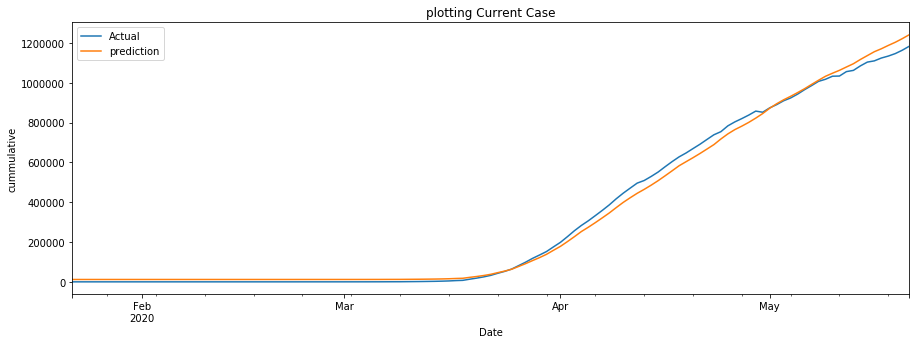

In [27]:
# See predictions
xplot = us_df.currentCase.copy()
xplot.index = us_df.Date
ag = xplot.plot(legend=True,label='Actual', figsize=(15,5))
df_predict.currentCase.plot(legend=True, label='prediction', ax=ag, title='plotting Current Case')
plt.ylabel('cummulative')

Text(0, 0.5, 'cummulative')

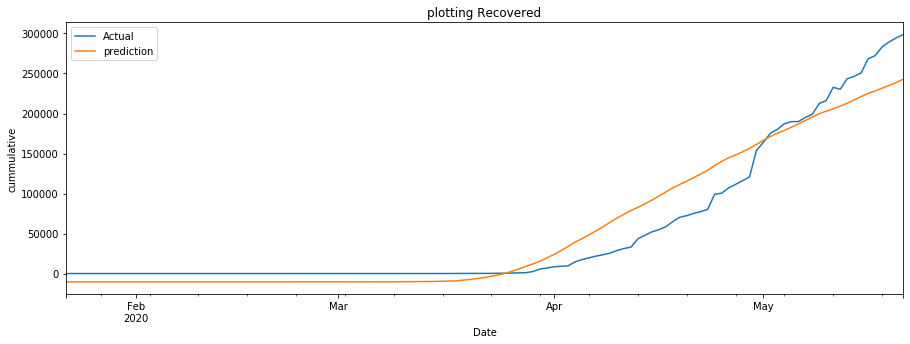

In [28]:
yplot = us_df.Recovered.copy()
yplot.index = us_df.Date
ah = yplot.plot(legend=True,label='Actual', figsize=(15,5))
df_predict.Recovered.plot(legend=True, label='prediction', ax=ah, title='plotting Recovered')
plt.ylabel('cummulative')

Text(0, 0.5, 'cummulative')

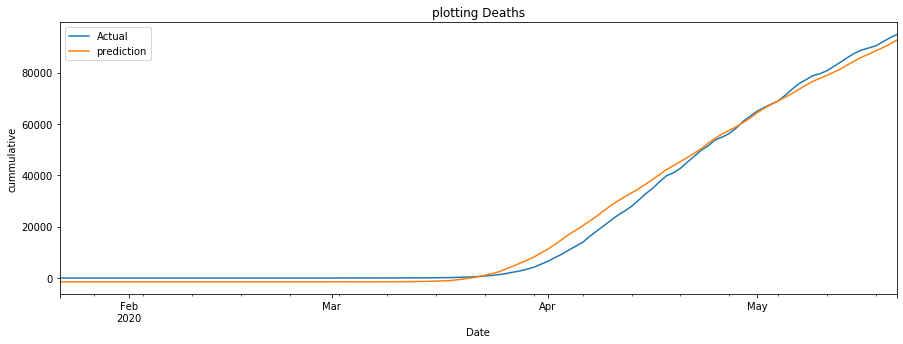

In [29]:
yplot = us_df.Deaths.copy()
yplot.index = us_df.Date
ah = yplot.plot(legend=True,label='Actual', figsize=(15,5))
df_predict.Deaths.plot(legend=True, label='prediction', ax=ah, title='plotting Deaths')
plt.ylabel('cummulative')

Text(0, 0.5, 'cummulative')

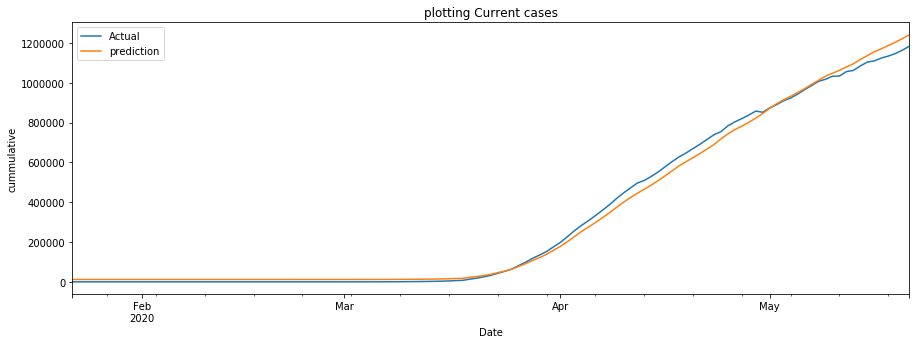

In [30]:
yplot = us_df.currentCase.copy()
yplot.index = us_df.Date
ah = yplot.plot(legend=True,label='Actual', figsize=(15,5))
df_predict.currentCase.plot(legend=True, label='prediction', ax=ah, title='plotting Current cases')
plt.ylabel('cummulative')

In [9]:
us_df.set_index('Date')

,Confirmed,Deaths,Recovered
Date,,,
2020-01-22,1.0,0.0,0.0
2020-01-23,1.0,0.0,0.0
2020-01-24,2.0,0.0,0.0
2020-01-25,2.0,0.0,0.0
2020-01-26,5.0,0.0,0.0
...,...,...,...
2020-05-17,1486757.0,89562.0,272265.0
2020-05-18,1508308.0,90347.0,283178.0
2020-05-19,1528568.0,91921.0,289392.0


In [10]:
us_df.reset_index()

,index,Date,Confirmed,Deaths,Recovered
0,29403,2020-01-22,1.0,0.0,0.0
1,29404,2020-01-23,1.0,0.0,0.0
2,29405,2020-01-24,2.0,0.0,0.0
3,29406,2020-01-25,2.0,0.0,0.0
4,29407,2020-01-26,5.0,0.0,0.0
...,...,...,...,...,...
116,29519,2020-05-17,1486757.0,89562.0,272265.0
117,29520,2020-05-18,1508308.0,90347.0,283178.0
118,29521,2020-05-19,1528568.0,91921.0,289392.0
119,29522,2020-05-20,1551853.0,93439.0,294312.0


In [11]:
#importing package
from fbprophet import Prophet

In [12]:
#Regroup the datasets into Confirmed, Deaths, Recovered, CurrentCase
confirmed = us_df[['Date','Confirmed']]
confirmed = confirmed.set_index('Date')
confirmed = confirmed.reset_index()

deaths = us_df[['Date','Deaths']]
deaths = deaths.set_index('Date')
deaths = deaths.reset_index()

recovered = us_df[['Date','Recovered']]
recovered = recovered.set_index('Date')
recovered = recovered.reset_index()

In [19]:
confirmed = confirmed.rename(columns={'Date':'ds', 'Confirmed': 'y'})
deaths = deaths.rename(columns={'Date':'ds', 'Deaths': 'y'})
recovered = recovered.rename(columns={'Date':'ds', 'Recovered': 'y'})

In [20]:
confirmed.head()

,ds,y
0,2020-01-22,1.0
1,2020-01-23,1.0
2,2020-01-24,2.0
3,2020-01-25,2.0
4,2020-01-26,5.0


In [21]:
deaths.head()

,ds,y
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0


In [22]:
recovered.head()

,ds,y
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0


In [24]:
m = Prophet( daily_seasonality=True)
m.fit(confirmed)
#m.fit(deaths)
#m.fit(recovered)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [25]:
futureDays = m.make_future_dataframe(periods=90)
futureDays.head(7)

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
5,2020-01-27
6,2020-01-28


In [26]:
confirmed_forecast = m.predict(futureDays)
#np.exp(confirmed_forecast)

In [27]:
confirmed_forecast=confirmed_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [28]:
confirmed_forecast

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-1.998563e+03,-8.047596e+03,3.932449e+03
1,2020-01-23,-6.773425e+02,-6.584297e+03,5.047409e+03
2,2020-01-24,1.693273e+03,-4.296176e+03,7.222305e+03
3,2020-01-25,2.237673e+03,-3.518302e+03,8.111929e+03
4,2020-01-26,8.852684e+02,-4.558711e+03,7.063821e+03
...,...,...,...,...
206,2020-08-15,3.712779e+06,3.159513e+06,4.316999e+06
207,2020-08-16,3.736086e+06,3.171892e+06,4.348765e+06
208,2020-08-17,3.759466e+06,3.182415e+06,4.377894e+06
209,2020-08-18,3.782922e+06,3.189337e+06,4.419090e+06


Text(0.5, 1, 'Confirmed US forecasting')

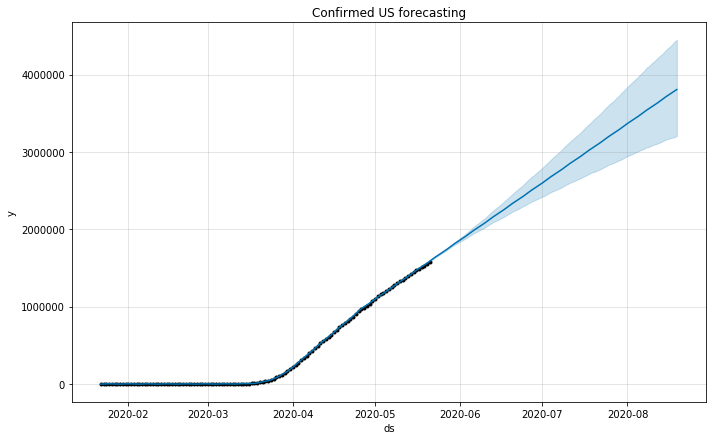

In [29]:
graph = m.plot(confirmed_forecast)
plt.title('Confirmed US forecasting')

In [ ]:
# Validation
pred_data = confirmed_forecast

In [30]:
pforecast_lower = pd.DataFrame(model.predict(pred_data.yhat_lower.values.reshape(-1,1)), 
                               columns=['Deaths','Recovered','currentCase'],
)

pforecast = pd.DataFrame(model.predict(pred_data.yhat.values.reshape(-1,1)),
                         columns=['Deaths','Recovered','currentCase'],
                         index=futureDays.ds)

pforecast_upper = pd.DataFrame(model.predict(pred_data.yhat_upper.values.reshape(-1,1)), 
                               columns=['Deaths','Recovered','currentCase'],
                         index=futureDays.ds)

NameError: name 'model' is not defined